---
layout: code-post
title: Training neural nets - Backpropagation
tags: [neural nets]
---

Following our foray into the expressive power of shallow neural
networks, let's train a shallow neural network instead of 
designing them by hand.


Outline:

0. Generating data
1. Backpropagation
2. Examples
3. PyTorch

## 0. Generating Data

Before we really get going, I'm going to set up some training data. For
this notebook, I'm going to uniformly generate points in a 10 x 10 square
with the bottom left corner at the origin. The points will be classified
by where the fall with respect to input functions. We'll mostly be using
linear functions to carve up our test space, so we'll create some helper
functions for those as well.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Functions for lines
class SlopeLine():
    """ a line defined by slope and intercept """
    def __init__(self, m, b):
        self.m = m
        self.b = b
        
    def y(self, x):
        return self.m * x + self.b
    
    def x(self, y):
        return (y - self.b) / self.m

def get_slope_line(point_1, point_2):
    """returns slope line object with line determined by the points
    where point_i = (x, y)"""
    
    m = (point_2[1] - point_1[1]) / (point_2[0] - point_1[0])
    b = point_1[1] - m * point_1[0]
    
    return SlopeLine(m, b)

# Functions to generate points
class Inequality():
    """
    given a function f(x) of one variable.
    we will test y < f(x) or y > f(x)
    for a point (x, y)
    """
    def __init__(self, func, ineq_type):
        self.func = func
        
        if ineq_type == '<':
            self.eval = self.less_than
        elif ineq_type == '>':
            self.eval = self.greater_than
        else:
            raise Exception("ineq_type must be '>' or '<'")
        
    def less_than(self, point):
        return point[:,1] < self.func(point[:,0])
    
    def greater_than(self, point):
        return point[:,1] > self.func(point[:,0])
    

def generate_points(n, inequality_lists):
    """ get n points in the 10x10 square classified by
    inequalities.
    
    inequality_lists should be a list of lists of inequalities.
    
    Points are evaluated to the positive class (1) by the
    interior lists if all the inequalities in that list
    are satisfied. Then, if any of the the interior lists
    return true, the point is classified as true.
    
    """
    data_x = np.random.uniform(0, 10, (n, 2))
    
    def evaluate_list(inequality_list):
        
        evals = np.array([ineq.eval(data_x) for ineq in inequality_list]) \
                  .transpose()
        return np.array([all(p) for p in evals])
    
    all_evals = np.array([evaluate_list(il) for il in inequality_lists]) \
                  .transpose()
    
    data_y = np.array([1 if any(p) else -1 for p in all_evals])
    
    data = {
        'x_1': data_x[:,0]
        ,'x_2': data_x[:,1]
        ,'y': data_y
    }
    return pd.DataFrame(data)

In [4]:
eye_1 = np.array([
    [2, 5]
    ,[3, 6]
    ,[4, 5]
    ,[3, 4]
    ,[2, 5]
])
eye_2 = eye_1 + [4, 0]
mouth = np.array([[2, 2], [8, 2], [5, 1], [2, 2]])

lines_eye_1 = [get_slope_line(eye_1[i], eye_1[i+1]) for i in range(len(eye_1) - 1)]
lines_eye_2 = [get_slope_line(eye_2[i], eye_2[i+1]) for i in range(len(eye_2) - 1)]
lines_mouth = [get_slope_line(mouth[i], mouth[i+1]) for i in range(len(mouth) - 1)]

ineq_eye_1 = [Inequality(lines_eye_1[0].y, '<'), Inequality(lines_eye_1[1].y, '<'),
              Inequality(lines_eye_1[2].y, '>'), Inequality(lines_eye_1[3].y, '>')]

ineq_eye_2 = [Inequality(lines_eye_2[0].y, '<'), Inequality(lines_eye_2[1].y, '<'),
              Inequality(lines_eye_2[2].y, '>'), Inequality(lines_eye_2[3].y, '>')]

ineq_mouth = [Inequality(lines_mouth[0].y, '<'), Inequality(lines_mouth[1].y, '>'), 
              Inequality(lines_mouth[2].y, '>')]

df = generate_points(10000, [ineq_eye_1, ineq_eye_2, ineq_mouth])

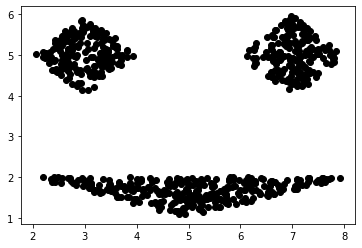

In [5]:
c = df['y'] == 1

plt.plot(df[c].x_1, df[c].x_2, 'ko')
#plt.plot(df[~c].x_1, df[~c].x_2, 'ro')
plt.show()

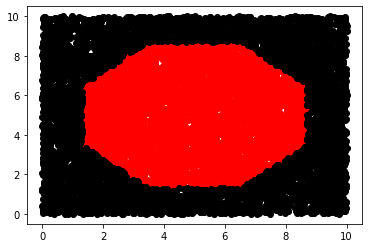

In [6]:
center = [5, 5]
r = 4

offset = -np.pi / 8 + .00001

points = r * np.array([[np.cos(i * np.pi / 4 + offset), np.sin(i * np.pi / 4 + offset)] for i in range(9)]) + center

inequalities = [[
    Inequality(get_slope_line(points[i], points[i+1]).y, '<' if i < 4 else '>') for i in range(8)
]]

df = generate_points(10000, inequalities)

c = df['y'] == 1

plt.plot(df[c].x_1, df[c].x_2, 'ro')
plt.plot(df[~c].x_1, df[~c].x_2, 'ko')
plt.show()

## 1. Backpropagation

Even though neural networks are not an example of convex optimization,
it has still proven useful to train the networks via stochastic gradient
descent (SGD). Even if the found minima are only local or not even
minima, this does not preclude their usefulness.

Let $f(x, W)$ be the output of the neural net with weights $W$ at
the input $x$. Previously, we had normalized the output by using the
sign function to map to $\pm1$. In this case we will not do this, leaving
the output layer to have the identity function as its activation function.
Since the desired values are $\pm1$, we will stick with the hinge loss,
which is defined as $\ell(x, y, W) = \max\{0, 1 - y f(x, W)\}$. As before,
if $1 - y f(x, W) \leq 0$, i.e., if the correct sign is being predicted,
then the hinge loss has the zero vetor as a subgradient (with respect to
$W$). Otherwise a subgradient is $- y\partial_W f(x, W)$. Thus in the 
update step we have to calculate the gradient of the neural network with
respect to the weights.

The backpropagation algorithm is used to calculate this gradient. As noted in 
the [activation functions](https://kevinnowland.com/code/2020/04/19/activation-functions.html)
post, feed forward neural networks are compositions of affine linear 
transformations (of which the weights are parameters) and component-wise 
activation functions. The structure of the composition suggests the
backpropagation algorithm, where derivatives with respect to the weights
in layers closer to the output layer can be used to calculate the
derivatives with respect to weights closer to the input layer.
The backpropagation algorithm actually consists of two parts, a forward
pass through the neural network to calculate inputs and outputs of
each layer and the backward pass to calculate the components of the
gradient.


In [7]:
class SimpleNN():
    """neural network with n hidden layers"""
    
    def __init__(self, w, sigma):
        self.w = w
        self.sigma = sigma
        self.o = [0 for i in range(len(self.w)+1)]
        self.a = [0 for i in range(len(self.w)+1)]
        
    def output(self, x):
        """ we assume that the row vector x already has 1 appended to it"""
        if type(x) == list:
            x = np.array(x)
            
        # this is not optimal programming... but it does say simple nn
        self.a[0] = x.transpose()
        self.o[0] = self.a[0]
        
        for i in range(1, len(self.o)):
            self.a[i] = np.matmul(self.w[i-1], self.o[i-1])
            self.o[i] = self.sigma[i](self.a[i])
            
        return self.o[-1].transpose()
    
def backward_pass(W, o, a, y, sigma_prime):
    """ calculates gradient given results of forward pass """
    delta = [0 for i in range(len(o))]
    sigma_prime_vals = [sigma_prime[i](a[i]) for i in range(len(a))]
    grad = [0 for i in range(len(W))]
    
    # the first step is governed by the choice of the loss 
    # and the output function
    delta[-1] = np.array([- y])
    
    # this is the rest of the backward pass
    for i in range(-2, -len(delta)-1, -1):
        delta[i] = np.matmul(W[i+1].transpose(), delta[i+1] * sigma_prime_vals[i+1])
        
    # this should be doable using numpy broadcasting
    for i in range(len(grad)):
        grad[i] = np.matmul(delta[i+1] * sigma_prime_vals[i+1], o[i].transpose())
    
    return grad

def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))

In [8]:
np.random.seed(12)

def sigma_constant(x):
    """ applies sigmoid function on first n-1 terms
    of nx1 array, and returns 1 to the last term"""
    o_1 = x.copy()
    o_1[:-1,] = sigmoid(o_1[:-1,])
    o_1[-1,] = 1
    return o_1

def sigma_constant_prime(x):
    """ applies sigmoid' on first n-1 terms
    returns 0 on last term """
    o_1 = x.copy()
    o_1[:-1,] = sigmoid_prime(o_1[:-1,])
    o_1[-1,] = 0
    return o_1


# need a 3x3 matrix to feed the first layer
# need a 1x3 for the second layer
w = [
    np.zeros((3, 3))
    ,np.zeros((1, 3))
]

# initialize the non-zero weights
w[0][:2, :] = np.random.uniform(-1, 1, (2, 3))
w[1] = np.random.uniform(-1, 1, (1, 3))

print('W^1 = \n', w[0])
print('W^2 = \n', w[1])

snn = SimpleNN(w, [lambda x: x, sigma_constant, lambda x: x])

W^1 = 
 [[-0.69167432  0.48009939 -0.47336997]
 [ 0.06747879 -0.97085008  0.83749402]
 [ 0.          0.          0.        ]]
W^2 = 
 [[ 0.80142971 -0.93315714  0.91389867]]


## Backpropagation

Let's recall the setup. We have a layer $V_t$ of $n_t$ neurons. The
input to $V_t$ is $a_t$ and the output is $o_t = \sigma_t(a_t)$. 
Also, $a_t = W^{t-1}o_{t-1}$, and $W^{t-1}$ is a matrix of size
$n_t\times n_{t-1}$. The activation function $s_t$ will act
componentwise on the $n_t$-dimensional vector $a_t$. $W^0$ is the
weights from the input layer, and $W^T$ is the weights from
the last hidden layer to the output layer, which consists of a single neuron
that has the identity function as its activator.

Let's examine how (the positive part of) the loss $\ell(x, y, W)=1-y f(x, W)$ 
depends on $w^T_k$, a weight from the last hidden layer to the output
layer. We calculate

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^T_k}}
    &= \frac{\partial}{\partial{w^T_k}}(1 - y\sigma_{T+1}'(W^To_T)) \\
    &= -y \sigma_{T+1}'(a_{T+1})o_{T-1, k}.
\end{align*}
$$

We get the $o_{T-1, k}$ term because $a_{T+1}=W^To_T = \sum_i w^T_i o_{T, i}$.
Now let's consider the weight $w^T_{k, n}$ from neuron $n$ in $V_{T-1}$ 
to neuron $k$ in $V_T$. For this partial derivative we first find that

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}}
    &= \frac{\partial}{\partial{w^{T-1}_{k, n}}}(1 - y \sigma_{T+1}(W^T\sigma_T(W^{T-1}o_{T-1}))) \\
    &= -y \sigma_{T+1}'(a_{T+1})\frac{\partial}{\partial{w^{T-1}_{k, n}}} W^T\sigma_T(W^{T-1}o_{T-1})
\end{align*}
$$

Stopping for a moment to consider this, $w^{T-1}_{k, n}$ only feeds neuron $k$ in $V_T$,
so only the $k$th component of $\sigma_T$ is affected. Since the output layer only has one neuron,
the only weight from this neuron is $w^T_k$, so we end up with

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}}
    &= -y \sigma_{T+1}'(a_{T+1}) w^T_k \sigma_{T, k}'(a_T) o_{T-1, n}.
\end{align*}
$$

Note that we've repeated $-y\sigma_{T+1}'(a_{T+1})$. Let's get a little ahead 
of ourselves define

$$
    \delta_{T+1} := -y, \quad
    \delta_{T, k} := \delta_{T+1,k}\sigma_{T+1}'(a_{T+1})w^T_k.
$$

Such that

$$
    \frac{\partial\ell}{\partial{w^T_k}} = \delta_{T+1}\sigma_{T+1}'(a_{T+1})o_{T-1, k},\quad
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}} = \delta_T\sigma_{T, k}'(a_T) o_{T-1, n}.
$$

This already shows how backpropogation might work. A first forward pass through the neural
net is necessary to calculate the $a_i$ and $o_i$, while on the backward pass we
calculate the derivates one layer at a time, from output to input, storing the $\delta$
values along the way to help calculate successive derivatives. However, since the output
layer only has one neuron, it's a little bit cheating to say that we are done, so
let's calculate a derivative with respect to $w^{T-2}_{n, m}$ to get the full scope of
the behavior. What changes here is that while $w^{T-2}_{n, m}$ only feeds neuron $n$
in $V_{T-1}$, but neuron $n$ in $V_{T-1}$ feeds every neuron in $V_T$, of which there are
multiple. So now the calculate looks like

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-2}_{n, m}}}
    &= -y \sigma_{T+1}'(a_{T+1})\sum_{i=1}^{n_T}w^T_i\sigma_{T, i}'(a_T)w^{T-1}_{i, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m} \\
    &= \sum_{i=1}^{n_T}\delta_{T, i}\sigma_{T, i}'(a_T)w^{T-1}_{i, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m}.
\end{align*}
$$

Therefore we define

$$
    \delta_{T-1, n} = \sum_{i=1}^{n_T}\delta_{T, i}\sigma_{T, i}'(a_T)w^{T-1}_{i, n}
$$

such that

$$
    \frac{\partial\ell}{\partial w^{T-2}_{n, m}} = \delta_{T-1, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m}.
$$

What we've shown is that the backward pass can be summarized by

$$
\begin{align*}
    \delta_{T+1} &= -y, \\
    \delta_{t} &= {}^TW^t(\delta_{t+1}*\sigma_{t+1}'(a_{t+1})), \\
    \frac{\partial\ell}{\partial w^t} &= (\delta_{t+1}*\sigma_{t+1}'(a_{t+1}))({}^To_t),
\end{align*}
$$

where ${}^TA$ is the transpose of $A$ and $(x*y)$ is the elementwise product.

Having shown way too much detail, let's implment our simple neural network 
and stochastic gradient descent using backpropagation.